In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2025-sep-dl-gen-ai-project/sample_submission.csv
/kaggle/input/2025-sep-dl-gen-ai-project/train.csv
/kaggle/input/2025-sep-dl-gen-ai-project/test.csv


In [2]:
# Wand Db login
import wandb
wandb.login(key="479ac211767b6279f7be89524ecce419e3ae84c6")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 23f1000559 (23f1000559-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Imports

In [3]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

2025-11-24 12:57:48.976668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763989069.520456      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763989069.639525      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# loading the dataset
df = pd.read_csv('/kaggle/input/2025-sep-dl-gen-ai-project/train.csv')
test_df = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/test.csv")

## EDA

In [5]:
print(df.shape)
print(test_df.shape)

(6827, 8)
(1707, 2)


In [6]:
df.head()

,id,text,anger,fear,joy,sadness,surprise,emotions
0,0,the dentist that did the work apparently did a...,1,0,0,1,0,['anger' 'sadness']
1,1,i'm gonna absolutely ~~suck~~ be terrible duri...,0,1,0,1,0,['fear' 'sadness']
2,2,"bridge: so leave me drowning calling houston, ...",0,1,0,1,0,['fear' 'sadness']
3,3,after that mess i went to see my now ex-girlfr...,1,1,0,1,0,['anger' 'fear' 'sadness']
4,4,"as he stumbled i ran off, afraid it might some...",0,1,0,0,0,['fear']


In [7]:
# Avg. Text length
df["text_len"]=df["text"].apply(lambda x: len(x.split()))
print(df["text_len"].mean())
print(df["text_len"].max())
print(df["text_len"].min())

15.684781016551927
89
1


In [8]:
# null values check
df['text'].isna().sum()

0

<Axes: >

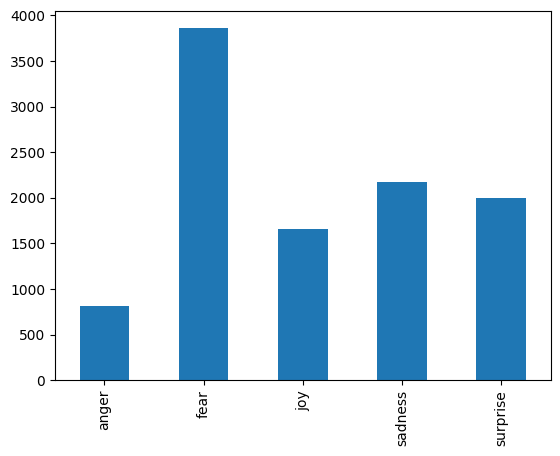

In [9]:
# frequency distribution of each plot
df[["anger","fear","joy","sadness","surprise"]].sum().plot(kind="bar")

<Axes: >

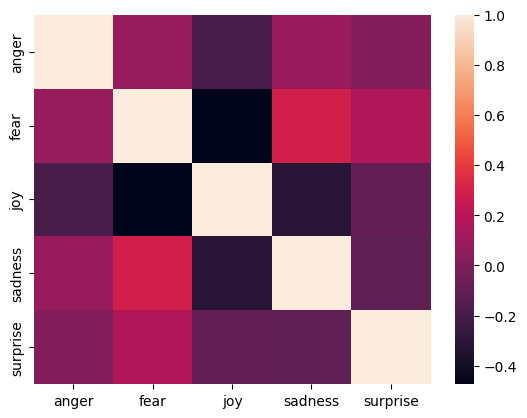

In [10]:
#Coorelation between emotions
import seaborn as sns
sns.heatmap(df[["anger","fear","joy","sadness","surprise"]].corr())

## Data preprocessing

In [11]:
# checking if the dataset has html entities
import re 
html_pat = re.compile(r"&[a-zA-Z0-9#]+;")
df["html_entity"]=df["text"].str.findall(html_pat)
df["html_entity"].value_counts().head(15)

html_entity
[]                6812
[&gt;]               8
[&amp;]              4
[&lt;, &gt;]         1
[&amp;, &amp;]       1
[&lt;]               1
Name: count, dtype: int64

In [12]:
# cleaning html entities
import html
df["text"] = df["text"].apply(html.unescape)

### Converting to Dataset

In [13]:
from datasets import Dataset
test_dataset = Dataset.from_pandas(test_df)


In [14]:
cols = ["anger","fear","joy","sadness","surprise"]
labels = df[cols].astype(float).values

In [15]:
labels

array([[1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       ...,
       [1., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [16]:
dataset = Dataset.from_dict({
    'text': df['text'].tolist(),
    'labels' : labels.tolist()
})

In [17]:
dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 6827
})

In [18]:
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

# tokenisation


In [19]:
model_name = "distilbert-base-uncased"  
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)


train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6144 [00:00<?, ? examples/s]

Map:   0%|          | 0/683 [00:00<?, ? examples/s]

Map:   0%|          | 0/1707 [00:00<?, ? examples/s]

In [20]:
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

## Model 

In [21]:
#Model 
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    problem_type="multi_label_classification"
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training loop

In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    report_to = "wandb",
    run_name="roberta-base-cleaned-v2",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    num_train_epochs=10,
    logging_steps=200,
    gradient_accumulation_steps=2
)

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()


/tmp/ipykernel_19/1297639760.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251124_125814-sebzb80x
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run roberta-base-cleaned-v2
wandb: ⭐️ View project at https://wandb.ai/23f1000559-indian-institute-of-technology-madras/huggingface
wandb: 🚀 View run at https://wandb.ai/23f1000559-indian-institute-of-technology-madras/huggingface/runs/sebzb80x
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
200,0.504400
400,0.387100
600,0.309500
800,0.275300
1000,0.217900
1200,0.196500
1400,0.148400
1600,0.132400
1800,0.103900
2000,0.091800


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=3840, training_loss=0.14268421532275777, metrics={'train_runtime': 744.5707, 'train_samples_per_second': 82.517, 'train_steps_per_second': 5.157, 'total_flos': 2034808101273600.0, 'train_loss': 0.14268421532275777, 'epoch': 10.0})

## Preds

In [24]:
# # threshold tuning
# from sklearn.metrics import f1_score
# val_preds = trainer.predict(val_dataset)
# val_probs = torch.sigmoid(torch.tensor(val_preds.predictions)).numpy()

# if val_probs.shape[0] == 5:
#     val_probs = val_probs.T
    
# val_labels = np.array(val_dataset["labels"]) 
# def find_best_threshold(y_true, y_prob):
#     thresholds = np.arange(0.1, 0.9, 0.02)
#     best_t = 0.5
#     best_f1 = 0
    
#     for t in thresholds:
#         preds = (y_prob > t).astype(int)
#         f1 = f1_score(y_true, preds)
#         if f1 > best_f1:
#             best_f1 = f1
#             best_t = t
    
#     return best_t, best_f1

# best_thresholds = []
# for i in range(val_labels.shape[1]):
#     t, f = find_best_threshold(val_labels[:, i], val_probs[:, i])
#     best_thresholds.append(t)
#     print(f"Label {i}: best threshold = {t:.3f}, F1 = {f:.3f}")

# best_thresholds

In [25]:
thresholds= [0.220, 0.300, 0.240, 0.440, 0.600]
preds = trainer.predict(test_dataset)
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()

if probs.shape[0] == 5:
    probs = probs.T

binary_preds = np.zeros_like(probs)

for i, t in enumerate(thresholds):
    binary_preds[:, i] = (probs[:, i] > t).astype(int)


In [26]:
# submission
output = pd.DataFrame(binary_preds, columns=["anger", "fear", "joy", "sadness", "surprise"])
output.insert(0, "id", test_df["id"])
output.to_csv("submission.csv", index=False)

In [27]:
!head -n 5 submission.csv
!wc -l submission.csv

id,anger,fear,joy,sadness,surprise
0,1.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


1708 submission.csv
